Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 128)      

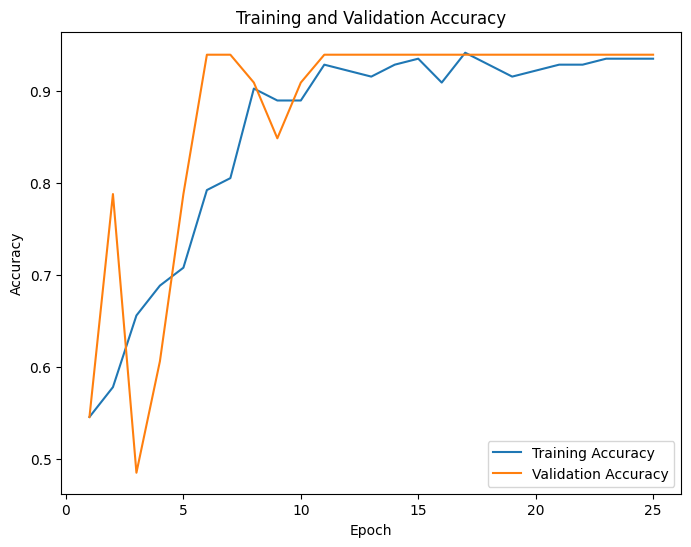

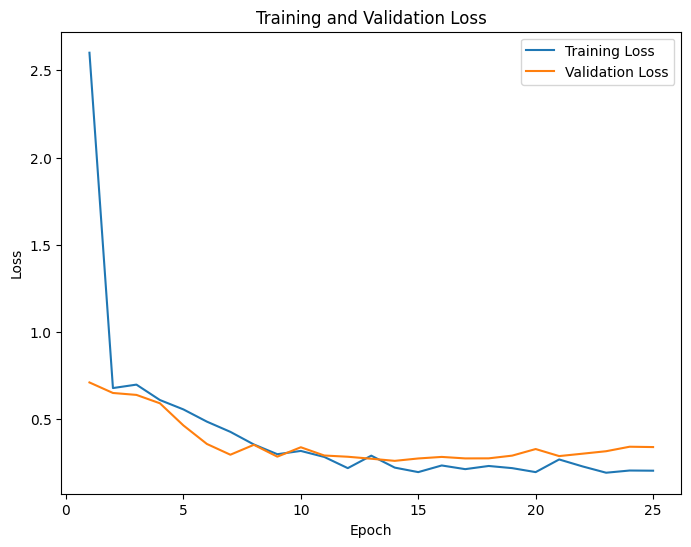

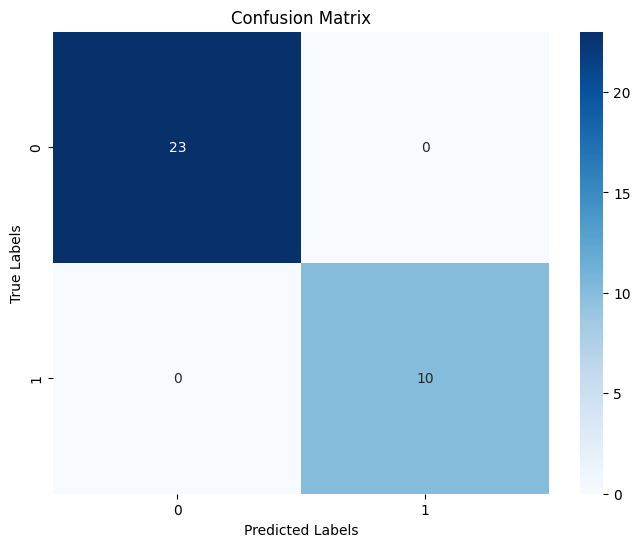

Testing Time: 0.51 seconds
Training Accuracy: 0.9350649118423462
Validation Accuracy: 0.939393937587738
Test Accuracy: 1.0
Overall Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:
[[23  0]
 [ 0 10]]
True Positives: 23
False Positives: 0
True Negatives: 10
False Negatives: 0


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

#defining preprocess function
def preprocess_image(image, target_size=(256, 256)):
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Normalize the pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0
    return image

#dataset loading and labeling
dataset_dir = r"/content/drive/MyDrive/MICC-F220"
images = []
labels = []
image_filenames = os.listdir(dataset_dir)

for filename in image_filenames:
    image_path = os.path.join(dataset_dir, filename)
    image = cv2.imread(image_path)
    if image is not None:
        images.append(preprocess_image(image))
        # Assuming the ground truth label is part of the image filename
        label = 1 if 'scale' in filename else 0
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

#split
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#defining cnn model
def create_copy_move_detection_model(input_shape=(256, 256, 3), num_classes=2):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output to feed into dense layers
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Apply dropout before the final dense layer

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

#create and compile model
input_shape = (256, 256, 3)
num_classes = 2
model = create_copy_move_detection_model(input_shape, num_classes)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

#training the model
start_time = time.time()
epochs = 25
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
end_time = time.time()

#Predict and Evaluate on Test Set
start_test_time = time.time()
y_pred = model.predict(X_test)
end_test_time = time.time()

testing_time_seconds = end_test_time - start_test_time

y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
epochs = np.arange(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print and plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Extract TP, FP, TN, FN from the confusion matrix
tp, fp, fn, tn = conf_matrix.ravel()

# Calculate overall accuracy
overall_accuracy = (tp + tn) / (tp + fp + tn + fn)

# Print evaluation metrics
print("Testing Time: {:.2f} seconds".format(testing_time_seconds))
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Test Accuracy:", accuracy)
print("Overall Accuracy:", overall_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)
print("True Positives:", tp)
print("False Positives:", fp)
print("True Negatives:", tn)
print("False Negatives:", fn)

In [ ]:
model.save("model_f220_25.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
